# Aesop Agent Statistics

Analysis of theorem proving experiments with different models and strategies.

In [34]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [35]:
# Load registry data from both models
registry_30b_path = Path("1_qwen3-coder-30b-instruct/full_defs_new_aesop_registry.json")
registry_480b_path = Path("2_qwen3-coder-480b-instruct/full_defs_new_aesop_registry.json")

# Load 30B model registry
with open(registry_30b_path, 'r') as f:
    registry_30b = json.load(f)

# Load 480B model registry
with open(registry_480b_path, 'r') as f:
    registry_480b = json.load(f)

print(f"30B Model Registry:")
print(f"  Total theorems solved: {len(registry_30b['theorems'])}")
print(f"  Source file: {registry_30b['lean_file']}")
print(f"  Last updated: {registry_30b['last_updated']}")

print(f"\n480B Model Registry:")
print(f"  Total theorems solved: {len(registry_480b['theorems'])}")
print(f"  Source file: {registry_480b['lean_file']}")
print(f"  Last updated: {registry_480b['last_updated']}")

# Load run metadata for each model
run_files_30b = sorted(Path("1_qwen3-coder-30b-instruct").glob("run_*/run_metadata.json"))
run_files_480b = sorted(Path("2_qwen3-coder-480b-instruct").glob("run_*/run_metadata.json"))

print(f"\n30B Model runs: {len(run_files_30b)}")
print(f"480B Model runs: {len(run_files_480b)}")


30B Model Registry:
  Total theorems solved: 97
  Source file: data/full_defs_new.lean
  Last updated: 2025-12-12 01:23:30

480B Model Registry:
  Total theorems solved: 105
  Source file: data/full_defs_new.lean
  Last updated: 2025-12-12 02:35:58

30B Model runs: 3
480B Model runs: 3


## Theorem Composition Analysis

Analyze the 124 theorems by category:
- Has @simp annotation
- Proven by naive aesop
- Proven by LLM-assisted aesop
- Not yet proven

In [36]:
# Load source file to check simp annotations and count total theorems
source_file = Path("../data/full_defs_new.lean")
with open(source_file, 'r') as f:
    source_content = f.read()

# Count total theorems and lemmas in source (matching theorem_extractor.py logic)
import re
lines = source_content.split('\n')
theorem_count = sum(1 for line in lines if line.strip().startswith('theorem '))
lemma_count = sum(1 for line in lines if line.strip().startswith('lemma '))
total_theorems = theorem_count + lemma_count

# Count @simp annotations
simp_pattern = r'@\[simp\]'
has_simp = len(re.findall(simp_pattern, source_content))

print(f"Total theorems in source file: {total_theorems} ({theorem_count} theorems + {lemma_count} lemmas)")
print(f"Theorems with @simp annotation: {has_simp}")

# Analyze both registries
def analyze_registry(registry_data, model_name):
    theorems = registry_data['theorems']
    # Check for both uppercase and lowercase method values
    naive_count = sum(1 for t in theorems.values() if t['method'].upper() == 'NAIVE')
    llm_count = sum(1 for t in theorems.values() if t['method'].upper() == 'LLM')
    
    print(f"\n{model_name}:")
    print(f"  Total solved: {len(theorems)} / {total_theorems} ({len(theorems)/total_theorems*100:.1f}%)")
    print(f"  Naive aesop: {naive_count}")
    print(f"  LLM-assisted: {llm_count}")
    print(f"  Not proven: {total_theorems - len(theorems)}")
    
    return {
        'total_solved': len(theorems),
        'naive': naive_count,
        'llm': llm_count,
        'not_proven': total_theorems - len(theorems)
    }

stats_30b = analyze_registry(registry_30b, "30B Model")
stats_480b = analyze_registry(registry_480b, "480B Model")

# Find theorems solved by both models
theorems_30b = set(registry_30b['theorems'].keys())
theorems_480b = set(registry_480b['theorems'].keys())

both_solved = theorems_30b & theorems_480b
only_30b = theorems_30b - theorems_480b
only_480b = theorems_480b - theorems_30b

print(f"\nComparison:")
print(f"  Solved by both: {len(both_solved)}")
print(f"  Only by 30B: {len(only_30b)}")
print(f"  Only by 480B: {len(only_480b)}")
if len(only_480b) > 0:
    print(f"\nTheorems only solved by 480B: {', '.join(sorted(only_480b))}")


Total theorems in source file: 124 (117 theorems + 7 lemmas)
Theorems with @simp annotation: 83

30B Model:
  Total solved: 97 / 124 (78.2%)
  Naive aesop: 81
  LLM-assisted: 16
  Not proven: 27

480B Model:
  Total solved: 105 / 124 (84.7%)
  Naive aesop: 81
  LLM-assisted: 24
  Not proven: 19

Comparison:
  Solved by both: 97
  Only by 30B: 0
  Only by 480B: 8

Theorems only solved by 480B: comp_assoc, eval_finset_sum, eval_multiset_prod, eval_sum, eval_surjective, eval₂_list_prod_noncomm, list_prod_comp, map_comp


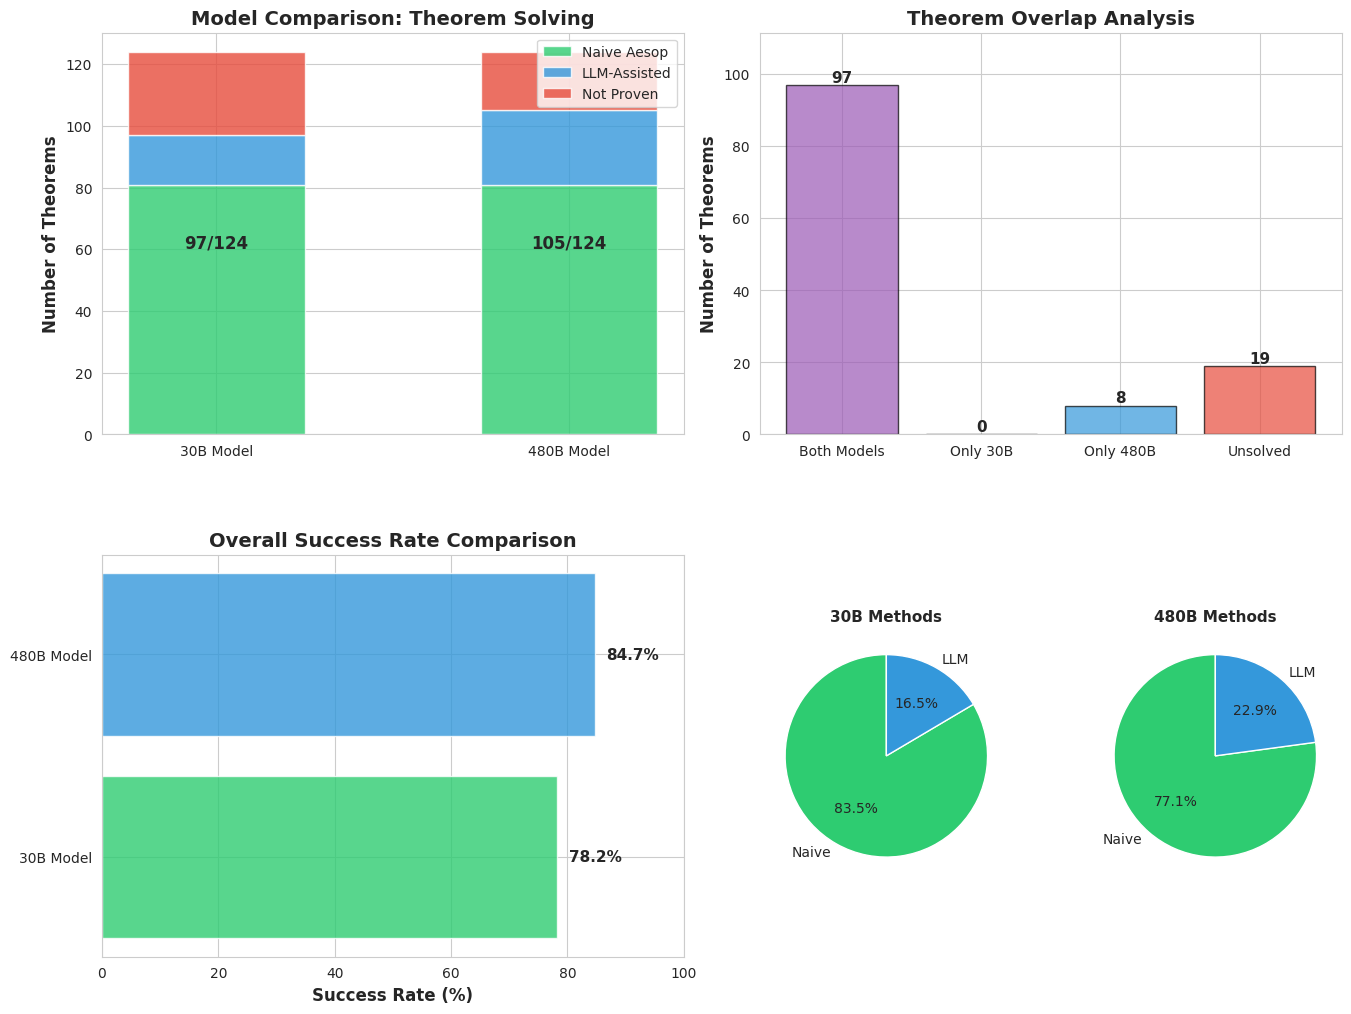


📊 Visualization saved as 'model_registry_comparison.png'


In [37]:
# Create comprehensive comparison visualization
fig = plt.figure(figsize=(16, 12))

# Create a grid layout
gs = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.3)

# 1. Model comparison - stacked bar chart
ax1 = fig.add_subplot(gs[0, 0:2])
models = ['30B Model', '480B Model']
naive_counts = [stats_30b['naive'], stats_480b['naive']]
llm_counts = [stats_30b['llm'], stats_480b['llm']]
not_proven = [stats_30b['not_proven'], stats_480b['not_proven']]

x_pos = range(len(models))
width = 0.5

p1 = ax1.bar(x_pos, naive_counts, width, label='Naive Aesop', color='#2ecc71', alpha=0.8)
p2 = ax1.bar(x_pos, llm_counts, width, bottom=naive_counts, label='LLM-Assisted', color='#3498db', alpha=0.8)
p3 = ax1.bar(x_pos, not_proven, width, bottom=[n+l for n, l in zip(naive_counts, llm_counts)], 
             label='Not Proven', color='#e74c3c', alpha=0.8)

ax1.set_ylabel('Number of Theorems', fontsize=12, fontweight='bold')
ax1.set_title('Model Comparison: Theorem Solving', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models)
ax1.legend(loc='upper right')
ax1.set_ylim(0, total_theorems * 1.05)

# Add total labels
for i, (model, total) in enumerate(zip(models, [stats_30b['total_solved'], stats_480b['total_solved']])):
    ax1.text(i, total_theorems/2, f'{total}/{total_theorems}', 
            ha='center', va='center', fontweight='bold', fontsize=12)

# 2. Venn diagram-style overlap
ax2 = fig.add_subplot(gs[0, 2:4])
categories = ['Both Models', 'Only 30B', 'Only 480B', 'Unsolved']
counts = [len(both_solved), len(only_30b), len(only_480b), 
          total_theorems - len(theorems_30b | theorems_480b)]
colors_venn = ['#9b59b6', '#2ecc71', '#3498db', '#e74c3c']

bars = ax2.bar(categories, counts, color=colors_venn, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Number of Theorems', fontsize=12, fontweight='bold')
ax2.set_title('Theorem Overlap Analysis', fontsize=14, fontweight='bold')
ax2.set_ylim(0, max(counts) * 1.15)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

# 3. Success rate comparison
ax3 = fig.add_subplot(gs[1, 0:2])
success_rates = {
    '30B Model': (stats_30b['total_solved'] / total_theorems) * 100,
    '480B Model': (stats_480b['total_solved'] / total_theorems) * 100
}

bars = ax3.barh(list(success_rates.keys()), list(success_rates.values()), 
                color=['#2ecc71', '#3498db'], alpha=0.8)
ax3.set_xlabel('Success Rate (%)', fontsize=12, fontweight='bold')
ax3.set_title('Overall Success Rate Comparison', fontsize=14, fontweight='bold')
ax3.set_xlim(0, 100)

for i, (model, rate) in enumerate(success_rates.items()):
    ax3.text(rate + 2, i, f'{rate:.1f}%', 
            va='center', fontweight='bold', fontsize=11)

# 4. Method breakdown pie charts
pie_data_30b = [stats_30b['naive'], stats_30b['llm']]
pie_data_480b = [stats_480b['naive'], stats_480b['llm']]
labels = ['Naive', 'LLM']
colors_pie = ['#2ecc71', '#3498db']

# 30B pie
ax_30b = fig.add_subplot(gs[1, 2])
ax_30b.pie(pie_data_30b, labels=labels, autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax_30b.set_title('30B Methods', fontsize=11, fontweight='bold')

# 480B pie
ax_480b = fig.add_subplot(gs[1, 3])
ax_480b.pie(pie_data_480b, labels=labels, autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax_480b.set_title('480B Methods', fontsize=11, fontweight='bold')

plt.savefig('model_registry_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Visualization saved as 'model_registry_comparison.png'")


## LLM Performance Over Runs

Track how many theorems each model proved across different runs.

In [38]:
# Parse run logs for both models
run_data = []

# Process 30B model runs
for run_file in run_files_30b:
    with open(run_file, 'r') as f:
        data = json.load(f)
    
    run_data.append({
        'run_name': data['run_name'],
        'start_time': data['start_time'],
        'model': '30B',
        'model_full': data['config']['model'],
        'naive_success': data['statistics']['naive_aesop_success'],
        'llm_success': data['statistics']['llm_aesop_success'],
        'total_proven': data['statistics']['naive_aesop_success'] + data['statistics']['llm_aesop_success'],
        'failed': data['statistics']['total_failures']
    })

# Process 480B model runs
for run_file in run_files_480b:
    with open(run_file, 'r') as f:
        data = json.load(f)
    
    run_data.append({
        'run_name': data['run_name'],
        'start_time': data['start_time'],
        'model': '480B',
        'model_full': data['config']['model'],
        'naive_success': data['statistics']['naive_aesop_success'],
        'llm_success': data['statistics']['llm_aesop_success'],
        'total_proven': data['statistics']['naive_aesop_success'] + data['statistics']['llm_aesop_success'],
        'failed': data['statistics']['total_failures']
    })

df_runs = pd.DataFrame(run_data)
df_runs = df_runs.sort_values(['model', 'start_time']).reset_index(drop=True)

# Add run number per model
df_runs['run_number'] = df_runs.groupby('model').cumcount() + 1

print("\n=== Run Summary ===")
print(df_runs[['model', 'run_number', 'naive_success', 'llm_success', 'total_proven', 'failed']])



=== Run Summary ===
  model  run_number  naive_success  llm_success  total_proven  failed
0   30B           1             82           14            96      28
1   30B           2              0            2             2      25
2   30B           3              0            0             0      25
3  480B           1             82           22           104      20
4  480B           2              0            2             2      17
5  480B           3              0            0             0      17


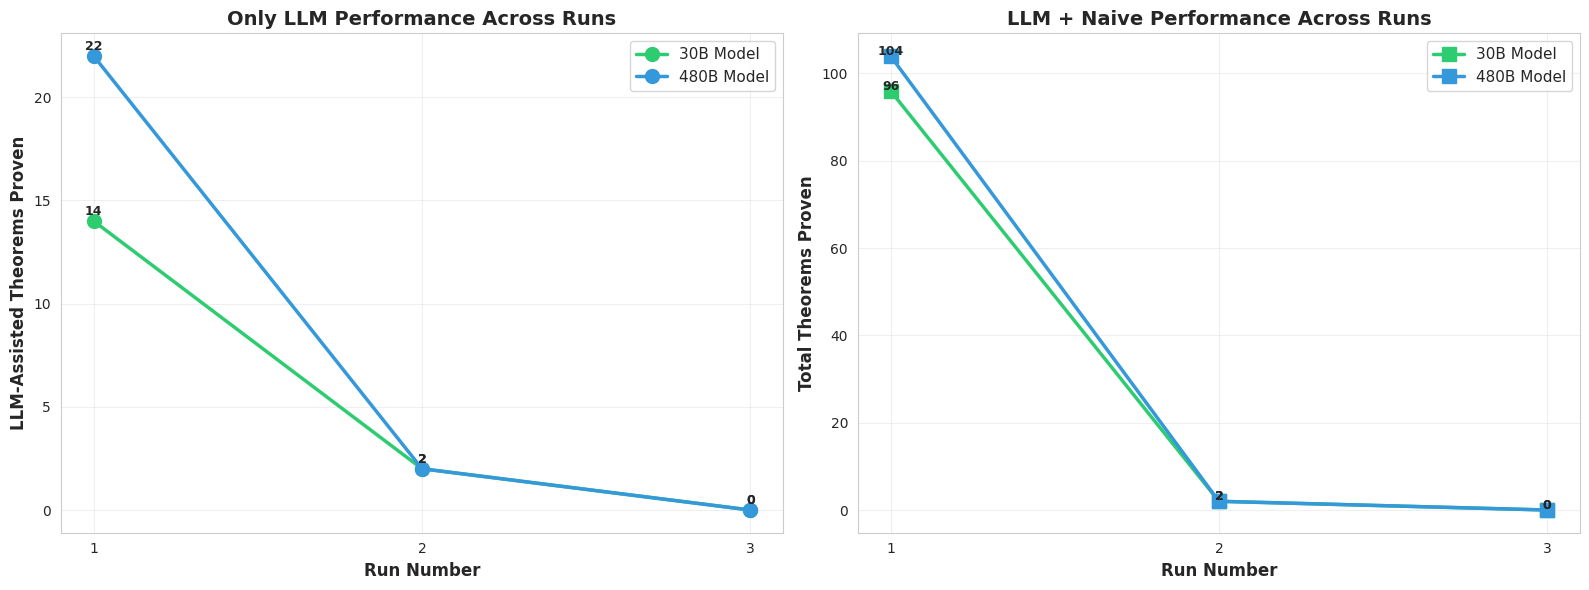

In [39]:
# Create line plots comparing both models over runs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

models = ['30B', '480B']
model_colors = {
    '30B': '#2ecc71',
    '480B': '#3498db'
}

# Plot 1: LLM successes over runs
for model in models:
    model_data = df_runs[df_runs['model'] == model]
    
    ax1.plot(model_data['run_number'], model_data['llm_success'], 
            marker='o', linewidth=2.5, markersize=10,
            label=f'{model} Model',
            color=model_colors[model])
    
    # Add data labels
    for x, y in zip(model_data['run_number'], model_data['llm_success']):
        ax1.text(x, y + 0.3, str(int(y)), ha='center', fontsize=9, fontweight='bold')

ax1.set_xlabel('Run Number', fontsize=12, fontweight='bold')
ax1.set_ylabel('LLM-Assisted Theorems Proven', fontsize=12, fontweight='bold')
ax1.set_title('Only LLM Performance Across Runs', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, max(df_runs['run_number']) + 1))

# Plot 2: Total success over runs
for model in models:
    model_data = df_runs[df_runs['model'] == model]
    
    ax2.plot(model_data['run_number'], model_data['total_proven'], 
            marker='s', linewidth=2.5, markersize=10,
            label=f'{model} Model',
            color=model_colors[model])
    
    # Add data labels
    for x, y in zip(model_data['run_number'], model_data['total_proven']):
        ax2.text(x, y + 0.3, str(int(y)), ha='center', fontsize=9, fontweight='bold')

ax2.set_xlabel('Run Number', fontsize=12, fontweight='bold')
ax2.set_ylabel('Total Theorems Proven', fontsize=12, fontweight='bold')
ax2.set_title('LLM + Naive Performance Across Runs', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(1, max(df_runs['run_number']) + 1))

plt.tight_layout()
plt.savefig('llm_performance_over_runs.png', dpi=300, bbox_inches='tight')
plt.show()


## Summary Statistics by Model

In [40]:
# Aggregate statistics by model
model_stats = df_runs.groupby('model').agg({
    'naive_success': ['mean', 'max', 'min', 'std'],
    'llm_success': ['mean', 'max', 'min', 'std'],
    'total_proven': ['mean', 'max', 'min', 'std'],
    'run_number': 'count'
}).round(2)

model_stats.columns = ['_'.join(col).strip() for col in model_stats.columns.values]
model_stats = model_stats.rename(columns={'run_number_count': 'num_runs'})

print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)
print(model_stats)

# Calculate improvement
print("\n" + "="*80)
print("COMPARATIVE ANALYSIS")
print("="*80)

avg_30b = df_runs[df_runs['model'] == '30B']['total_proven'].mean()
avg_480b = df_runs[df_runs['model'] == '480B']['total_proven'].mean()
improvement = ((avg_480b - avg_30b) / avg_30b) * 100 if avg_30b > 0 else 0

print(f"Average total proven (30B): {avg_30b:.2f}")
print(f"Average total proven (480B): {avg_480b:.2f}")
print(f"Improvement: {improvement:+.2f}%")

llm_avg_30b = df_runs[df_runs['model'] == '30B']['llm_success'].mean()
llm_avg_480b = df_runs[df_runs['model'] == '480B']['llm_success'].mean()
llm_improvement = ((llm_avg_480b - llm_avg_30b) / llm_avg_30b) * 100 if llm_avg_30b > 0 else 0

print(f"\nAverage LLM success (30B): {llm_avg_30b:.2f}")
print(f"Average LLM success (480B): {llm_avg_480b:.2f}")
print(f"LLM Improvement: {llm_improvement:+.2f}%")



MODEL PERFORMANCE SUMMARY
       naive_success_mean  naive_success_max  naive_success_min  \
model                                                             
30B                 27.33                 82                  0   
480B                27.33                 82                  0   

       naive_success_std  llm_success_mean  llm_success_max  llm_success_min  \
model                                                                          
30B                47.34              5.33               14                0   
480B               47.34              8.00               22                0   

       llm_success_std  total_proven_mean  total_proven_max  total_proven_min  \
model                                                                           
30B               7.57              32.67                96                 0   
480B             12.17              35.33               104                 0   

       total_proven_std  num_runs  
model                 

/tmp/ipykernel_1667858/600057758.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data_to_plot, labels=['30B Model', '480B Model'],


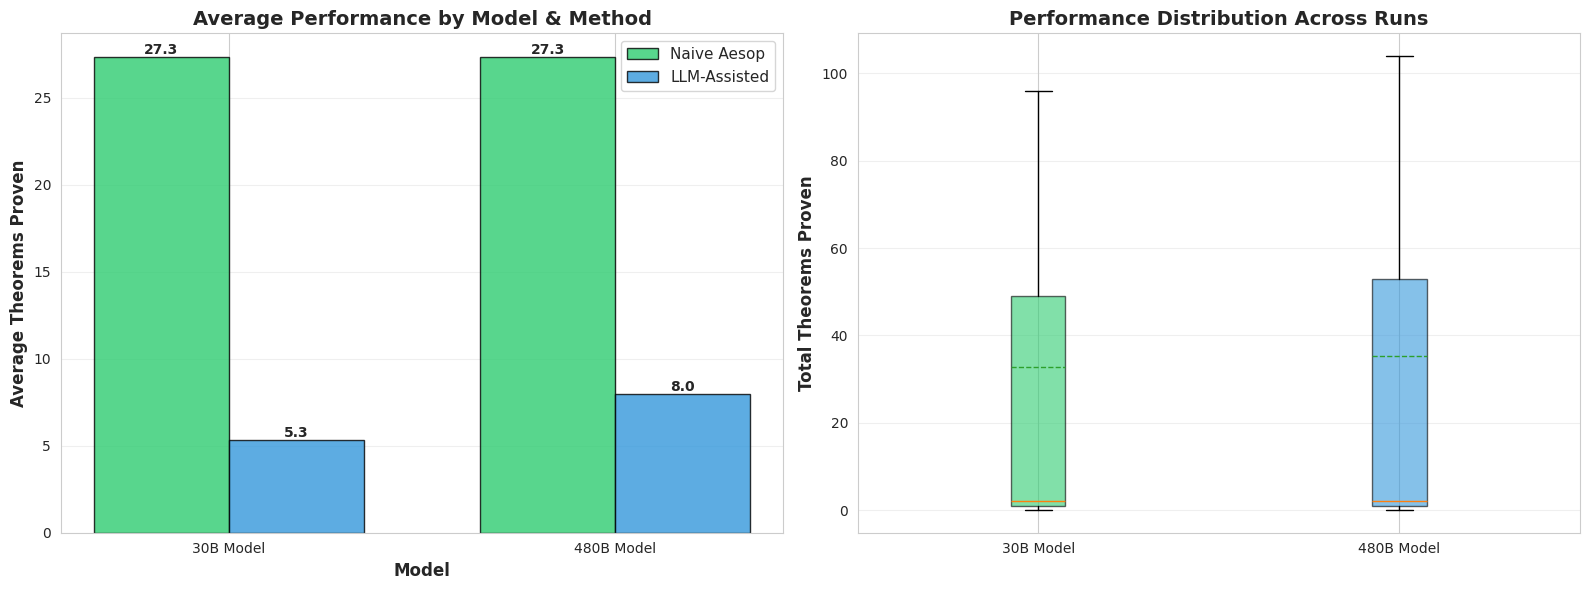


📊 All visualizations saved!


In [41]:
# Create comprehensive comparison charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Average performance by method
model_avg = df_runs.groupby('model')[['naive_success', 'llm_success']].mean()

x = range(len(model_avg))
width = 0.35

bars1 = ax1.bar([i - width/2 for i in x], model_avg['naive_success'], 
       width, label='Naive Aesop', color='#2ecc71', alpha=0.8, edgecolor='black')
bars2 = ax1.bar([i + width/2 for i in x], model_avg['llm_success'], 
       width, label='LLM-Assisted', color='#3498db', alpha=0.8, edgecolor='black')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Theorems Proven', fontsize=12, fontweight='bold')
ax1.set_title('Average Performance by Model & Method', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([f'{m} Model' for m in model_avg.index])
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Chart 2: Success rate distribution (box plot)
data_to_plot = [
    df_runs[df_runs['model'] == '30B']['total_proven'],
    df_runs[df_runs['model'] == '480B']['total_proven']
]

bp = ax2.boxplot(data_to_plot, labels=['30B Model', '480B Model'],
                 patch_artist=True, showmeans=True, meanline=True)

# Color the boxes
colors = ['#2ecc71', '#3498db']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax2.set_ylabel('Total Theorems Proven', fontsize=12, fontweight='bold')
ax2.set_title('Performance Distribution Across Runs', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 All visualizations saved!")
